In [1]:
import torch

from models.mmppp import IMMPpp
from models.modules import FC_vec

from loader.Toy_dataset import Toy, toy_visualizer, pallete
from models.lbf import LfD, Gaussian_basis, phi, vbf

import matplotlib.pyplot as plt

import numpy as np

device = 'cuda:0'

Toy split training | torch.Size([15, 201, 2])


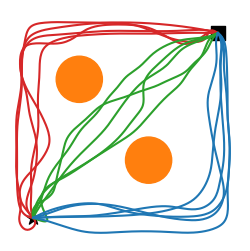

In [2]:
ds = Toy(root='datasets/EXP2')
dl = torch.utils.data.DataLoader(ds, batch_size=5)
fig, axs = plt.subplots(1, 1, figsize=(12, 3))
toy_visualizer(ds.env, axs, traj=ds.data, label=ds.targets)

In [31]:
encoder = FC_vec(
    in_chan=60,
    out_chan=2,
    l_hidden=[512, 512],
    activation=['elu', 'elu'],
    out_activation='linear'
)
decoder = FC_vec(
    in_chan=2,
    out_chan=60,
    l_hidden=[512, 512],
    activation=['elu', 'elu'],
    out_activation='linear'
)

mmppp = IMMPpp(
    encoder,
    decoder,
    dof=2,
    b=30,
    h_mul=1,
    iso_reg=1,
    basis='Gaussian',
    mode='vmp',
    via_points=[[0.8, 0.8], [-0.8, -0.8]]
)
mmppp.to(device)

IMMPpp(
  (encoder): FC_vec(
    (net): Sequential(
      (0): Linear(in_features=60, out_features=512, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=512, out_features=2, bias=True)
    )
  )
  (decoder): FC_vec(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=512, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=512, out_features=60, bias=True)
    )
  )
)

In [32]:
opt = torch.optim.Adam(mmppp.parameters(), lr=0.0001)
for epoch in range(1000):
    for x, y in dl:
        train_results = mmppp.train_step(x.to(device), optimizer=opt)
        train_loss = train_results["loss"]
    if epoch%50 == 0:
        print(f"[Epoch: {epoch}] Loss: {train_loss}")

[Epoch: 0] Loss: 5.855712890625
[Epoch: 50] Loss: 0.6196000576019287
[Epoch: 100] Loss: 0.4368372857570648
[Epoch: 150] Loss: 0.9047589898109436
[Epoch: 200] Loss: 0.7189648151397705
[Epoch: 250] Loss: 0.542003333568573
[Epoch: 300] Loss: 0.5204199552536011
[Epoch: 350] Loss: 0.6339101791381836
[Epoch: 400] Loss: 0.5662863850593567
[Epoch: 450] Loss: 0.3297165632247925
[Epoch: 500] Loss: 1.346321702003479
[Epoch: 550] Loss: 0.3897823691368103
[Epoch: 600] Loss: 0.6790404915809631
[Epoch: 650] Loss: 0.2228359580039978
[Epoch: 700] Loss: 0.5120596885681152
[Epoch: 750] Loss: 0.815021812915802
[Epoch: 800] Loss: 0.30475738644599915
[Epoch: 850] Loss: 0.5761850476264954
[Epoch: 900] Loss: 0.36934787034988403
[Epoch: 950] Loss: 0.2640473246574402


(-18.711757087707518,
 17.554191017150877,
 -5.9431023597717285,
 10.787256717681885)

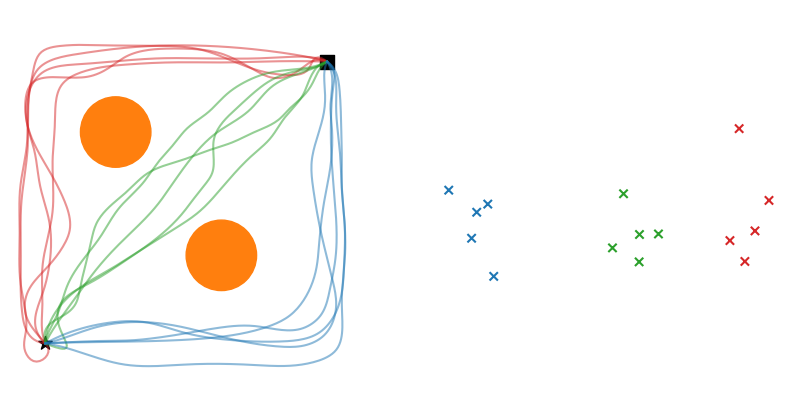

In [34]:
n_components = 3
n_samples = 300
alpha1 = 0.5
alpha2 = 0.3

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

toy_visualizer(
    ds.env, 
    axs[0], 
    traj=ds.data, 
    label=ds.targets, 
    alpha=alpha1)

w = mmppp.get_w_from_traj(ds.data.to(device))
latent_values = mmppp.encode(w).detach().cpu()
axs[1].scatter(
    latent_values[:,0], 
    latent_values[:,1],
    c=[pallete[i] for i in ds.targets],
    marker='x',
    )
axs[1].axis('equal')
axs[1].axis('off')

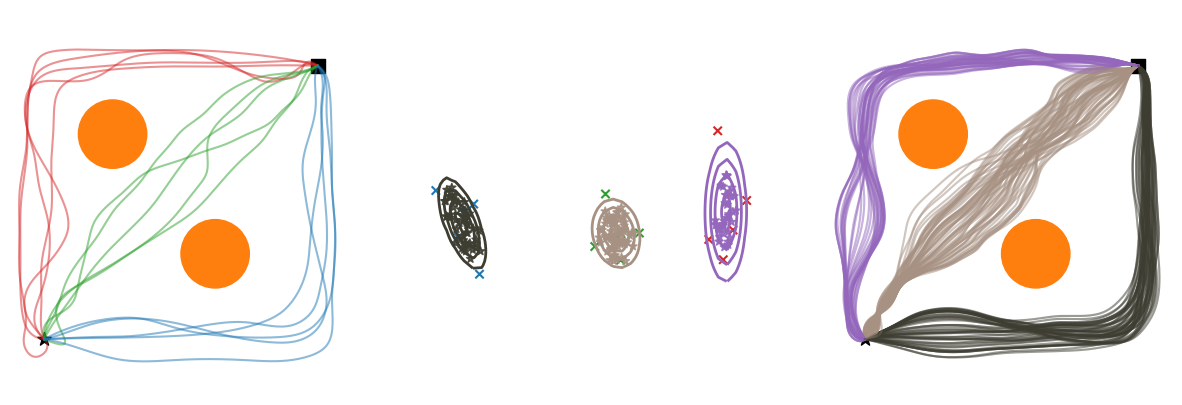

In [38]:
n_components = 3
n_samples = 300
alpha1 = 0.5
alpha2 = 0.3

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

toy_visualizer(
    ds.env, 
    axs[0], 
    traj=ds.data, 
    label=ds.targets, 
    alpha=alpha1)

w = mmppp.get_w_from_traj(ds.data.to(device))
latent_values = mmppp.encode(w).detach().cpu()
axs[1].scatter(
    latent_values[:,0], 
    latent_values[:,1],
    c=[pallete[i] for i in ds.targets],
    marker='x',
    )
axs[1].axis('equal')
axs[1].axis('off')

mmppp.fit_GMM(ds.data.to(device), n_components=n_components)
mmppp.gmm_thr = mmppp.gmm_thr + 1.5 ## to exclude samples from distrib. tails 
dict_samples = mmppp.sample(
    n_samples, 
    device=device, 
    traj_len=201,
    clipping=True
)
q_traj = dict_samples['q_traj_samples'].detach().cpu()
z_samples = dict_samples['z_samples'].detach().cpu()

axs[1].scatter(
    z_samples[:,0], 
    z_samples[:,1],
    c=[pallete[i] for i in 10-dict_samples['cluster_samples']],
    alpha=0.6,
    marker='*',
    )

sample_y = dict_samples['cluster_samples'].numpy()

xmin, xmax = axs[1].get_xbound()
ymin, ymax = axs[1].get_ybound()
for i, (mu, cov) in enumerate(zip(mmppp.gmm.means_, mmppp.gmm.covariances_)):
    tempZ = z_samples[sample_y == i]
    x = np.linspace(xmin, xmax, 40)
    y = np.linspace(ymin, ymax, 40)
    xx, yy = np.meshgrid(x, y) 
    delta = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1) - mu.reshape(1, -1)

    zz = np.exp(np.diagonal(
        -(delta@np.linalg.inv(cov)@delta.transpose())
    )/2)
    
    c = sample_y[sample_y == i].reshape(-1,1)
    contour = axs[1].contour(
        xx.reshape(40, 40), 
        yy.reshape(40, 40), 
        zz.reshape(40, 40),
        levels=[0.3, 0.5, 0.7, 0.9, 0.9999], 
        colors=pallete[10-i],
        linewidths=2,
        )
    
toy_visualizer(
    ds.env, 
    axs[2], 
    traj=q_traj, 
    label=10-dict_samples['cluster_samples'], 
    alpha=alpha2)